## MasterProject SoSe22: "Non-Intrusive Load Monitoring" (NILM)

- Start to get familiar with one of the publicly available data sets **RAE**, as described by Stephen Makonin et al. in their 2019 paper "RAE: The Rainforest Automation Energy Dataset for Smart Grid Meter Data Analysis".
- First inspection of *house1_power_blk1.csv*.


### Tech Preamble

In [37]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

### Load Data

In [2]:
# Read input file: (There is probably a more elegant way...)
# Skip header and keep total power consumption ('main') followed by 24 submeters ('sub1' .. 'sub24').
# Skip first two columns containing 'timestamp' in seconds and some interval total values.
file = open('../data/house1_power_blk1.csv', 'rb')
data = np.loadtxt(file, delimiter=",", skiprows=1, usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26))

In [3]:
# Check dimensions:
print("data shape (samples, features): ", data.shape)
print("data contains ", data.shape[0]/ (24*3600), " days")

data shape (samples, features):  (777600, 25)
data contains  9.0  days


In [4]:
## Create labels for house 1: ONLY 24 submeters! (copy from house1_labels.txt)

# Numbers of submeters:
labels_num = np.arange(1,25,1)

# Text labels:
labels_long = ['Kitchen Wall Oven L1','Kitchen Wall Oven L2','Kitchen Counter Plugs L1','Kitchen Counter Plugs L2',
               'Clothes Dryer L1','Clothes Dryer L2','Upstairs Bedroom AFCI Arc-Fault Plugs','Kitchen Fridge',
               'Clothes Washer','Kitchen Dishwasher','Furnace & Hot Water Unit (incl. Furnace Room Plug)',
               'Basement Plugs & Lights (incl. Outside Plugs)','Heat Pump L1','Heat Pump L2','Garage Sub-Panel L1',
               'Garage Sub-Panel L2','Upstairs Plugs & Lights L1 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Upstairs Plugs & Lights L2 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Basement Blue Plugs (incl. Ent. TV/Amp/DVD/PVR)','Bathrooms (incl. 3 GFCI Plugs, 2 Lights, 1 Vent Fan, Chest Freezer)',
               'Rental Suite Sub-Panel L1','Rental Suite Sub-Panel L2','Misc. Plugs (incl. Dining Room, Gas Cooktop, Microwave)',
               'Home Office (incl. Telco/Cable/Net/Security Equip.)']

In [5]:
## Try to reproduce plot of all loads for one day for house 1:
## Note: stackplot needs transposed data!

# Create time axis for one day:
time = range(24*3600)

# Transpose submeter data and extract first day:
data_transp = np.transpose(data[:,1:])
data_transp_d1 = data_transp[:,:24*3600]

Text(0, 0.5, 'Power [W]')

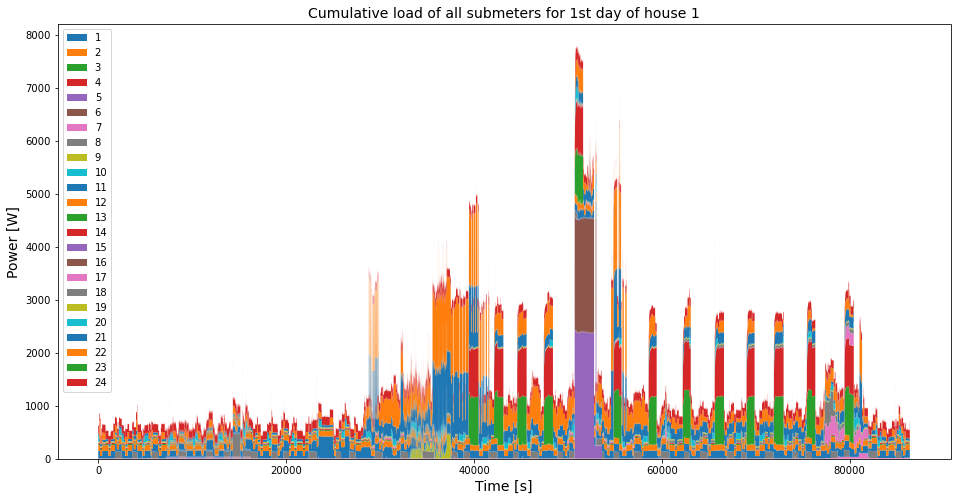

In [6]:
# Plot:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, data_transp_d1, labels=labels_num)
plt.legend(loc='upper left')
plt.title('Cumulative load of all submeters for 1st day of house 1', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Power [W]', fontsize=14)

In [7]:
## Further aggregate submeters to end up with 10 classes:

# Initialize storage for aggregate transposed submeter data:
data_transp_agg = np.zeros((10,len(data)))

## Manually aggragate submeters, as in Makonin et al. 2019 paper:

# Garage: Submeters 15, 16
data_transp_agg[0] = data_transp[14] + data_transp[15]

# Clothes Dryer: Submeters 5, 6
data_transp_agg[1] = data_transp[4] + data_transp[5]

# HVAC & Heat Pump: Submeters 11, 13, 14
data_transp_agg[2] = data_transp[10] + data_transp[12] + data_transp[13]

# Rental Suite: Submeters 21, 22
data_transp_agg[3] = data_transp[20] + data_transp[21]

# Plugs & Lights: Submeters 3, 4, 7, 12, 17, 18, 19, 20, 23
data_transp_agg[4] = data_transp[2] + data_transp[3] + data_transp[6] + data_transp[11] + data_transp[16] + data_transp[17] + data_transp[18] + data_transp[19] + data_transp[22]

# Wall Oven: Submeters 1, 2
data_transp_agg[5] = data_transp[0] + data_transp[1]

# Fridge: Submeter 8
data_transp_agg[6] = data_transp[7]

# Clothes Washer: Submeter 9
data_transp_agg[7] = data_transp[8]

# Dish Washer: Submeter 10
data_transp_agg[8] = data_transp[9]

# Home Office: Submeter 24
data_transp_agg[9] = data_transp[23]

## Create labels for aggregate submeters:
labels_long_agg = ['Garage','Clothes Dryer','HVAC & Heat Pump','Rental Suite','Plugs & Lights','Wall Oven',
                   'Fridge','Clothes Washer','Dish Washer','Home Office']

In [8]:
# Plausibility Check: Sum of aggregated submeters must equal total energy consumption in raw data. 
# Expect zero difference!
np.sum(np.sum(data_transp_agg,axis=0)-data[:,0])

0.0

Text(0, 0.5, 'Power [W]')

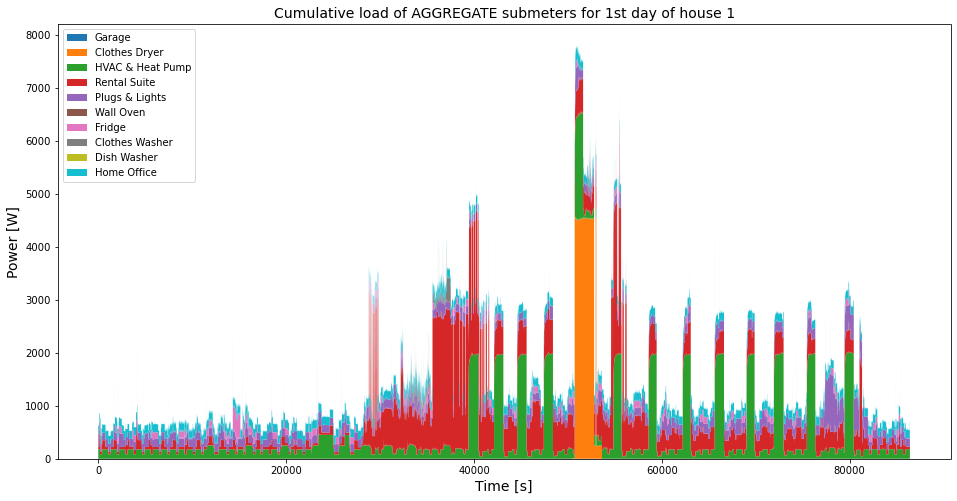

In [9]:
# Plot aggregate submeter data:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(time, data_transp_agg[:,:24*3600], labels=labels_long_agg)
plt.legend(loc='upper left')
plt.title('Cumulative load of AGGREGATE submeters for 1st day of house 1', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Power [W]', fontsize=14)

### Disaggregation using CNN network

Inspired by [Kelly and Knottenbelt, 2015](https://arxiv.org/pdf/1507.06594.pdf) paper "Neural NILM: Deep Neural Networks Applied to Energy Disaggregation" try to develop some CNN model.

Keep it very simple for the beginning: 

- Start with only two appliances
- Create target values for each appliance as binary value 0/1, if appliance is off/on.

In [10]:
## Inspect 24 submeter signals individually:

# Get mean load for each submeter over whole 9 days in house 1:
mean_load = np.round(np.mean(data_transp, axis=1),1)

# Get average using time (= non-zero load) in relation to total time span:
avg_usage = np.round(np.sum((data_transp!=0),axis=1) / len(data),2)

# Print results:
for i in range(len(labels_long)):
    print("submeter",i+1,":",labels_long[i])
    print("mean load [W]: ", mean_load[i])
    print("avg usage [%]: ", avg_usage[i]*100,"\n")

submeter 1 : Kitchen Wall Oven L1
mean load [W]:  0.0
avg usage [%]:  0.0 

submeter 2 : Kitchen Wall Oven L2
mean load [W]:  1.0
avg usage [%]:  99.0 

submeter 3 : Kitchen Counter Plugs L1
mean load [W]:  0.0
avg usage [%]:  0.0 

submeter 4 : Kitchen Counter Plugs L2
mean load [W]:  10.1
avg usage [%]:  100.0 

submeter 5 : Clothes Dryer L1
mean load [W]:  24.4
avg usage [%]:  4.0 

submeter 6 : Clothes Dryer L2
mean load [W]:  20.8
avg usage [%]:  1.0 

submeter 7 : Upstairs Bedroom AFCI Arc-Fault Plugs
mean load [W]:  29.5
avg usage [%]:  100.0 

submeter 8 : Kitchen Fridge
mean load [W]:  48.9
avg usage [%]:  44.0 

submeter 9 : Clothes Washer
mean load [W]:  2.7
avg usage [%]:  5.0 

submeter 10 : Kitchen Dishwasher
mean load [W]:  17.5
avg usage [%]:  6.0 

submeter 11 : Furnace & Hot Water Unit (incl. Furnace Room Plug)
mean load [W]:  128.0
avg usage [%]:  100.0 

submeter 12 : Basement Plugs & Lights (incl. Outside Plugs)
mean load [W]:  119.7
avg usage [%]:  100.0 

submete

In [11]:
## Start with submeter 8  (Kitchen Frigde, 48.9W mean load and 44% avg usage time) and
##            submeter 10 (Kitchen Dishwasher, 17.5W mean load and 6% avg usage time).

# Concatenate submeters 8 and 10:
data_transp_8_10 = np.concatenate([data_transp[7:8], data_transp[9:10]])

# Create binary target: Appliance on/off as 1/0, swap axes to have dimension (samples, features):
target_bin = np.swapaxes((data_transp_8_10 != 0).astype(int), 0, 1)

# Get total load of these two appliances, used as input:
input_8_10 = np.sum(data_transp_8_10, axis=0)

# Check dimensions:
print("input dimension: ", input_8_10.shape)
print("bin. target dimension: ", target_bin.shape)

input dimension:  (777600,)
bin. target dimension:  (777600, 2)


Text(0, 0.5, 'Power [W]')

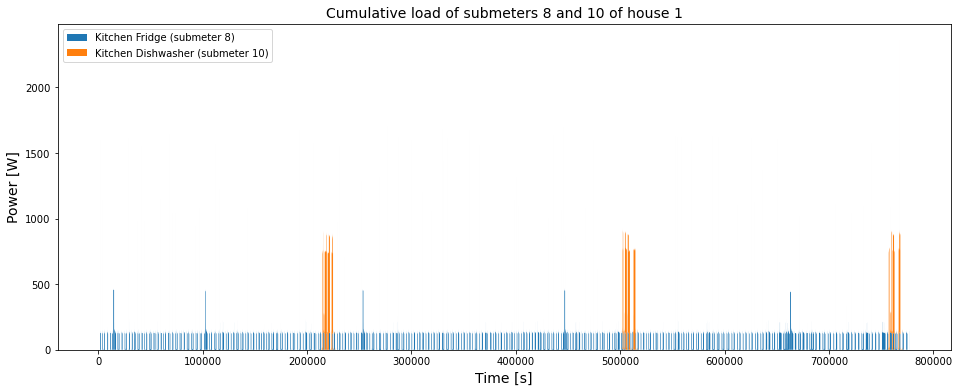

In [12]:
# Plot aggregate submeter data for submeters 8 and 10:
fig, ax = plt.subplots(figsize=(16, 6))
ax.stackplot(range(len(data)), data_transp_8_10, labels=['Kitchen Fridge (submeter 8)', 'Kitchen Dishwasher (submeter 10)'])
plt.legend(loc='upper left')
plt.title('Cumulative load of submeters 8 and 10 of house 1', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Power [W]', fontsize=14)

In [54]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

# Specify input length:
input_length = 60

# Split input values into sequences of specified length:
input_8_10_split = split_sequence(input_8_10, input_length)

# Reshape inputs to have third dimension (num features):
input_8_10_split = np.reshape(input_8_10_split, (input_8_10_split.shape[0], input_8_10_split.shape[1], 1))

# Split binary targets into sequences of the same length:
target_bin_split = split_sequence(target_bin, input_length)

# Then adjust targets: If appliance is ON for at least ONE second within 60 sec intervall, then set target = 1
targets = np.max(target_bin_split, axis=1)

# Dimension check:
print("input dimension (samples, time steps): ", np.shape(input_8_10_split))
print("target dimension (samples, time steps, features): ", np.shape(targets))

input dimension (samples, time steps):  (777541, 60, 1)
target dimension (samples, time steps, features):  (777541, 2)


In [55]:
## Scale inputs to [0,1] using min-max-scaling: Substract min and divide by (max - min)

# Get min and max on WHOLE input series:
input_max = np.max(input_8_10_split)
input_min = np.min(input_8_10_split)

# Scale:
inputs = (input_8_10_split - input_min) / (input_max - input_min)

## Split inputs and targets into train and validation sets:

# Get number of train samples: 80% of ALL samples
n_train = int(0.8 * len(inputs))

# Split:
train_input = inputs[:n_train]
val_input = inputs[n_train:]
train_target = targets[:n_train]
val_target = targets[n_train:]

## Dimension check:
print("train inputs (samples, time steps): ", train_input.shape)
print("val inputs (samples, time steps): ", val_input.shape)
print("\ntrain targets (samples, time steps, features): ", train_target.shape)
print("val targets (samples, time steps, features): ", val_target.shape)

train inputs (samples, time steps):  (622032, 60, 1)
val inputs (samples, time steps):  (155509, 60, 1)

train targets (samples, time steps, features):  (622032, 2)
val targets (samples, time steps, features):  (155509, 2)


In [97]:
## Set up simple CNN model
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=(input_length, 1), strides=1))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=8, strides=1))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(units=20, activation = 'linear'))
model.add(Dense(units=2, activation = 'sigmoid'))

# Get model summary:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 54, 10)            80        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 54, 10)            0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 27, 10)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 20, 20)            1620      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 20, 20)            0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 10, 20)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 200)             

In [98]:
# Compile model:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['acc'])

# Train model:
history = model.fit(train_input, train_target, epochs=3, batch_size=100, verbose=1, validation_data=(val_input, val_target))

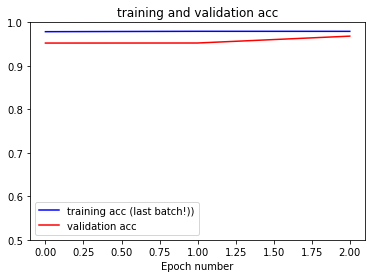

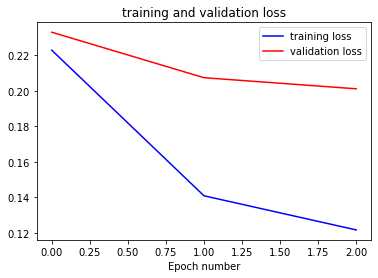

In [79]:
# plot train and val_acc 
plt.plot(history.history['acc'], color = 'blue', label = 'training acc (last batch!))')
plt.plot(history.history['val_acc'], color = 'red', label = 'validation acc')
plt.xlabel('Epoch number')
plt.ylim(0.5, 1)
plt.title('training and validation acc')
plt.legend()
plt.show()

# plot train and val_loss
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('training and validation loss')
plt.legend()
plt.show()  

In [99]:
## Get model predictions:
train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

In [100]:
## Convert to binary predictions:
train_pred_bin = (train_pred > 0.5).astype(int)
val_pred_bin = (val_pred > 0.5).astype(int)

In [101]:
## For comparision: Accuracy of UNTRAINED model:

train_acc [subm1, subm2]:  [94.83 58.24]
val_acc [subm1, subm2]:  [94.38 55.31]


In [96]:
## Calculate accuracy on train and validation data manually:
train_acc = np.sum((train_pred_bin==train_target), axis=0) / len(train_target)
val_acc = np.sum((val_pred_bin==val_target), axis=0) / len(val_target)

# Check accuracy:
print("train_acc [subm1, subm2]: ", np.round(train_acc*100, 2))
print("val_acc [subm1, subm2]: ", np.round(val_acc*100, 2))

train_acc [subm1, subm2]:  [96.45 97.13]
val_acc [subm1, subm2]:  [96.5  93.25]


In [ ]:
# Keep in mind: Fridge shows spike load when switching on in first second!

# NEXT:
# Does that work?
# Increase number of appliances!
# Try to predict switching events!
# ...

# Then try (bi-directional) LSTM model